Data Quality and Preparation - cleaning dataset for all the datasets provided

In [63]:
#importing all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:


# Loading all CSV files
applications = pd.read_csv("applications.csv", low_memory=False)
branches = pd.read_csv("branches.csv")
loans = pd.read_csv("loans.csv")
defaults = pd.read_csv("defaults.csv")
transactions = pd.read_csv("transactions.csv")
customers = pd.read_csv("customers.csv")


In [65]:
# 1. Data Quality and Preparation

# --- 1. Check basic info ---
print("Loans info:")
print(loans.info())
print("\nDefaults info:")
print(defaults.info())
print("\nBranches info:")
print(branches.info())

# --- 2. Missing values ---
print("\nMissing values per dataset:")
print(loans.isnull().sum())
print(defaults.isnull().sum())
print(branches.isnull().sum())

# --- 3. Remove duplicates ---
loans.drop_duplicates(inplace=True)
defaults.drop_duplicates(inplace=True)
branches.drop_duplicates(inplace=True)

# --- 4. Standardize date formats ---
date_cols_loans = ["Disbursal_Date", "Repayment_Date"]
for col in date_cols_loans:
    if col in loans.columns:
        loans[col] = pd.to_datetime(loans[col], errors="coerce")

if "Default_Date" in defaults.columns:
    defaults["Default_Date"] = pd.to_datetime(defaults["Default_Date"], errors="coerce")

# --- 5. Handle outliers ---
def cap_outliers(df, col):
    if col in df.columns:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
        df[col] = np.where(df[col] < lower, lower,
                          np.where(df[col] > upper, upper, df[col]))
        return df

for col in ["Loan_Amount", "Interest_Rate"]:
    if col in loans.columns:
        loans = cap_outliers(loans, col)

if "Default_Amount" in defaults.columns:
    defaults = cap_outliers(defaults, "Default_Amount")

# --- 6. Drop irrelevant columns (example) ---
irrelevant_cols = ["Notes", "Misc_Details"]  # adjust based on your dataset
loans = loans.drop(columns=[c for c in irrelevant_cols if c in loans.columns], errors="ignore")




Loans info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Loan_ID               90000 non-null  object 
 1   Customer_ID           90000 non-null  object 
 2   Loan_Amount           90000 non-null  int64  
 3   Interest_Rate         90000 non-null  float64
 4   Loan_Term             90000 non-null  int64  
 5   Disbursal_Date        90000 non-null  object 
 6   Repayment_Start_Date  90000 non-null  object 
 7   Repayment_End_Date    90000 non-null  object 
 8   Loan_Status           90000 non-null  object 
 9   Overdue_Amount        90000 non-null  int64  
 10  EMI_Amount            90000 non-null  int64  
 11  Collateral_Details    59806 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 8.2+ MB
None

Defaults info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data col

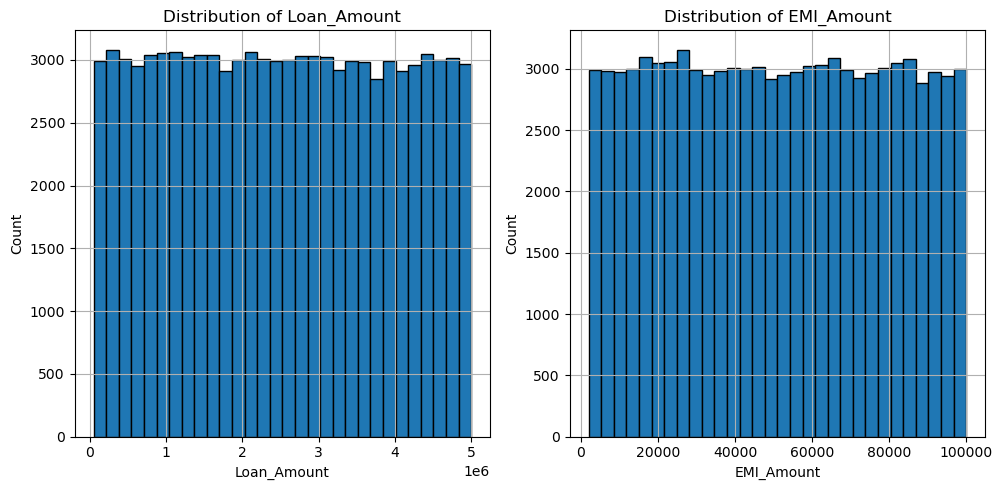

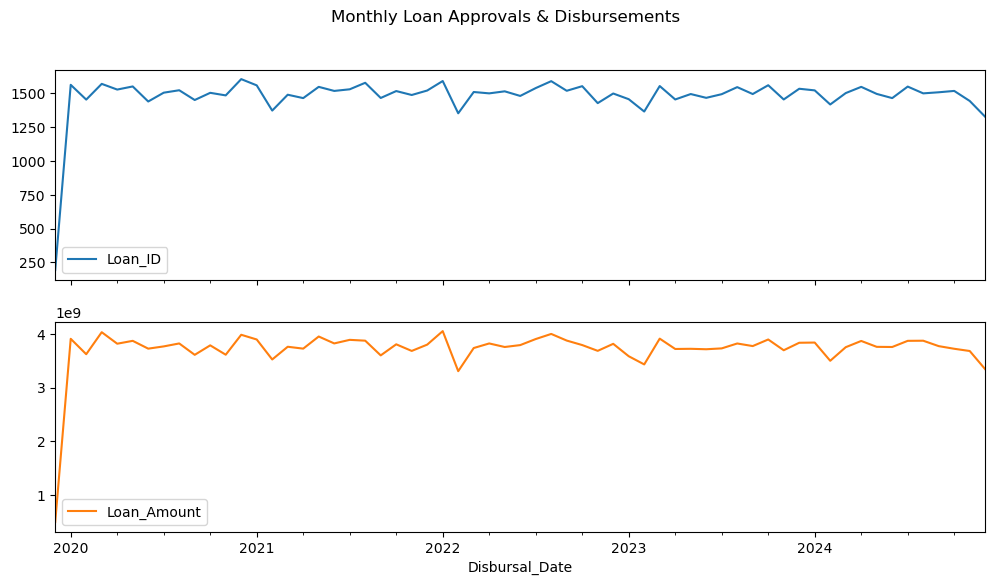

In [66]:
# 2. Descriptive Analysis


# --- Convert dates ---
loans["Disbursal_Date"] = pd.to_datetime(loans["Disbursal_Date"], errors="coerce")
if "Default_Date" in defaults.columns:
    defaults["Default_Date"] = pd.to_datetime(defaults["Default_Date"], errors="coerce")

# --- 1. Distribution of Loan_Amount, EMI_Amount, Credit_Score ---
plt.figure(figsize=(15,5))

for i, col in enumerate(["Loan_Amount", "EMI_Amount", "Credit_Score"]):
    if col in loans.columns:
        plt.subplot(1, 3, i+1)
        loans[col].hist(bins=30, edgecolor="black")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Count")

plt.tight_layout()
plt.show()

# --- 2. Regional trends in loan disbursement and defaults ---
if "Region" in loans.columns:
    regional_loans = loans.groupby("Region")["Loan_Amount"].sum()
    regional_defaults = loans.merge(defaults, on="Loan_ID", how="inner").groupby("Region")["Default_Amount"].sum()

    regional_summary = pd.DataFrame({
        "Total_Loans": regional_loans,
        "Total_Defaults": regional_defaults
    }).fillna(0)

    regional_summary.plot(kind="bar", figsize=(10,5))
    plt.title("Regional Loan Disbursements vs Defaults")
    plt.ylabel("Amount")
    plt.show()

# --- 3. Monthly trends in loan approvals & disbursements ---
monthly_trends = loans.set_index("Disbursal_Date").resample("ME").agg({
    "Loan_ID": "count",
    "Loan_Amount": "sum"
})

monthly_trends.plot(y=["Loan_ID", "Loan_Amount"], subplots=True, figsize=(12,6), legend=True)
plt.suptitle("Monthly Loan Approvals & Disbursements")
plt.show()

Correlation between Loan Attributes and Default_Flag:
                Loan_Amount  Interest_Rate  Default_Flag
Loan_Amount       1.000000      -0.003201     -0.003313
Interest_Rate    -0.003201       1.000000     -0.003750
Default_Flag     -0.003313      -0.003750      1.000000


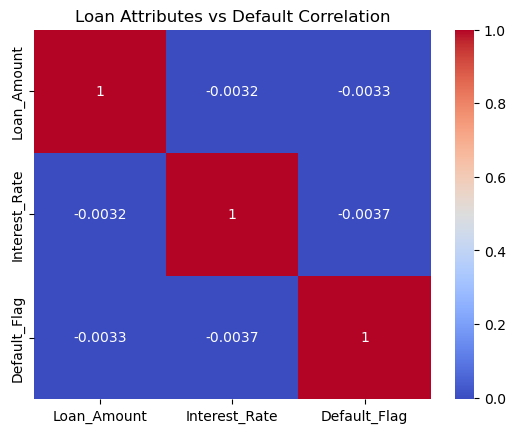


Pairwise correlations:
                 EMI_Amount  Overdue_Amount  Default_Amount
EMI_Amount        1.000000        0.000386        0.007650
Overdue_Amount    0.000386        1.000000       -0.010207
Default_Amount    0.007650       -0.010207        1.000000


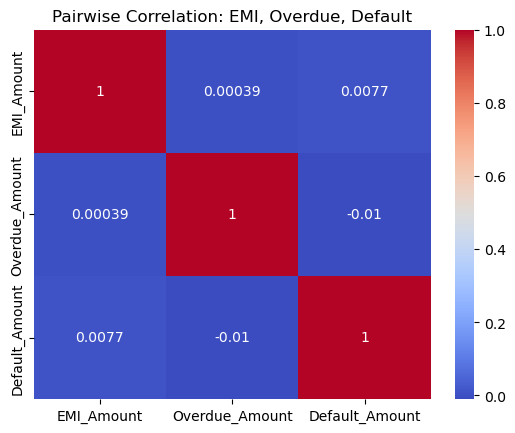

In [67]:
#3. Default Risk Analysis

# --- 1. Create Default_Flag ---
loans["Default_Flag"] = loans["Loan_ID"].isin(defaults["Loan_ID"]).astype(int)

# --- 2. Correlation between Loan Attributes and Defaults ---
candidate_cols = ["Loan_Amount", "Interest_Rate", "Credit_Score", "Default_Flag"]
available_cols = [col for col in candidate_cols if col in loans.columns]

loan_corr = loans[available_cols].corr()
print("Correlation between Loan Attributes and Default_Flag:\n", loan_corr)

sns.heatmap(loan_corr, annot=True, cmap="coolwarm")
plt.title("Loan Attributes vs Default Correlation")
plt.show()

# --- 3. Pairwise Correlation Heatmap (EMI, Overdue, Default) ---
loans_defaults = loans.merge(defaults[["Loan_ID", "Default_Amount"]], on="Loan_ID", how="left")

pairwise_cols = [col for col in ["EMI_Amount", "Overdue_Amount", "Default_Amount"] if col in loans_defaults.columns]
pairwise_corr = loans_defaults[pairwise_cols].corr()
print("\nPairwise correlations:\n", pairwise_corr)

sns.heatmap(pairwise_corr, annot=True, cmap="coolwarm")
plt.title("Pairwise Correlation: EMI, Overdue, Default")
plt.show()

# --- 4. Branch Metrics and Defaults ---
if "Branch_ID" in loans.columns and "Branch_ID" in branches.columns:
    branch_defaults = loans.groupby("Branch_ID")["Default_Flag"].mean()
    branch_merged = branches.merge(branch_defaults, on="Branch_ID", how="left")

    branch_cols = [c for c in ["Delinquent_Loans", "Loan_Disbursement_Amount", "Default_Flag"] if c in branch_merged.columns]
    branch_corr = branch_merged[branch_cols].corr()

    print("\nCorrelation between Branch Metrics and Defaults:\n", branch_corr)

    sns.heatmap(branch_corr, annot=True, cmap="coolwarm")
    plt.title("Branch Metrics vs Default Rates")
    plt.show()


In [68]:
#4. Branch and Regional Performance


# 1. Rank branches by Loan Disbursement Volume

branch_disbursement_rank = branches.sort_values(
    by="Loan_Disbursement_Amount", ascending=False
)[["Branch_Name", "Region", "Loan_Disbursement_Amount"]]
print("\nTop Branches by Loan Disbursement:\n", branch_disbursement_rank.head())


# 2. Rank branches by Processing Time Efficiency

branch_processing_rank = branches.sort_values(
    by="Avg_Processing_Time", ascending=True
)[["Branch_Name", "Region", "Avg_Processing_Time"]]
print("\nTop Branches by Processing Efficiency:\n", branch_processing_rank.head())


# 3. Rank branches by Default Rates & Recovery Rates

# Default rate = Delinquent / Total Active Loans
branches["Default_Rate"] = (
    branches["Delinquent_Loans"] / branches["Total_Active_Loans"]
)

# Recovery rates from defaults dataset
default_recovery = defaults.groupby("Loan_ID").agg(
    {"Default_Amount": "sum", "Recovery_Amount": "sum"}
).reset_index()
default_recovery["Recovery_Rate"] = (
    default_recovery["Recovery_Amount"] / default_recovery["Default_Amount"]
)

# Overall recovery rate
overall_recovery_rate = (
    default_recovery["Recovery_Amount"].sum() / default_recovery["Default_Amount"].sum()
)
print("\nOverall Recovery Rate:", round(overall_recovery_rate * 100, 2), "%")

# Branch-level default rate ranking
branch_default_rank = branches.sort_values(
    by="Default_Rate", ascending=False
)[
    ["Branch_Name", "Region", "Total_Active_Loans", "Delinquent_Loans", "Default_Rate"]
]
print("\nBranches ranked by Default Rate:\n", branch_default_rank.head())


# 4. Compare branch performance across regions

region_performance = branches.groupby("Region").agg(
    {
        "Loan_Disbursement_Amount": "sum",
        "Avg_Processing_Time": "mean",
        "Delinquent_Loans": "sum",
        "Total_Active_Loans": "sum",
    }
).reset_index()

# Compute regional default rate
region_performance["Default_Rate"] = (
    region_performance["Delinquent_Loans"] / region_performance["Total_Active_Loans"]
)

print("\nRegional Performance:\n", region_performance)



Top Branches by Loan Disbursement:
                      Branch_Name   Region  Loan_Disbursement_Amount
35                     Kara-Bahl     East                 499562869
13           Bhatti, Rau and Sem    North                 482327541
11                      Kaul Inc     West                 465469874
47            Chawla-Subramanian  Central                 464419943
34  Malhotra, Boase and Malhotra  Central                 449109596

Top Branches by Processing Efficiency:
                    Branch_Name     Region  Avg_Processing_Time
49                   Sani-Kale      North                    1
46               Chawla-Tandon       East                    2
41                   Kar-Jaggi       West                    2
17  Sandhu, Magar and Sachdeva  Northeast                    2
44                Solanki-Shah      South                    3

Overall Recovery Rate: 24.31 %

Branches ranked by Default Rate:
              Branch_Name     Region  Total_Active_Loans  Delinquent_L

In [69]:
# 5.customer_segmentation


# --- Merge to link loan and customer info ---
data = loans.merge(customers, on='Customer_ID', how='left')

# --- 1. Create Segments ---
# Income Segments
data['Income_Segment'] = pd.cut(
    data['Annual_Income'],
    bins=[0, 500000, 1000000, 2000000, float('inf')],
    labels=['Low', 'Middle', 'Upper-Middle', 'High']
)

# Credit Score Segments
data['Credit_Segment'] = pd.cut(
    data['Credit_Score'],
    bins=[0, 600, 750, 850],
    labels=['Low', 'Medium', 'High']
)

# --- 2. Identify High-Risk and High-Value Groups ---
high_risk = data[(data['Credit_Segment'] == 'Low') | (data['Loan_Status'] == 'Overdue')]
high_value = data[(data['Income_Segment'] == 'High') & (data['Credit_Segment'] == 'High')]

print("High-Risk Customers:")
print(high_risk[['Customer_ID', 'Annual_Income', 'Credit_Score', 'Loan_Status']].head(), "\n")

print("High-Value Customers:")
print(high_value[['Customer_ID', 'Annual_Income', 'Credit_Score', 'Loan_Status']].head(), "\n")

# --- 3. Analyze Repayment Behavior ---
repayment_behavior = (
    data.groupby(['Income_Segment', 'Credit_Segment', 'Loan_Status'], observed=False)
    .size()
    .unstack(fill_value=0)
)

print("Repayment Behavior by Segment:")
print(repayment_behavior)


High-Risk Customers:
  Customer_ID  Annual_Income  Credit_Score Loan_Status
0     C045929         634102           343      Active
1     C038991         957347           589      Closed
2     C046662         644217           832     Overdue
3     C040268        1946687           517      Active
4     C067057         245626           481     Overdue 

High-Value Customers:
Empty DataFrame
Columns: [Customer_ID, Annual_Income, Credit_Score, Loan_Status]
Index: [] 

Repayment Behavior by Segment:
Loan_Status                    Active  Closed  Overdue
Income_Segment Credit_Segment                         
Low            Low               2785    2793     2723
               Medium            1332    1311     1343
               High               939     877      857
Middle         Low               4573    4641     4585
               Medium            2272    2303     2190
               High              1443    1498     1477
Upper-Middle   Low               9161    9130     9142
      


Correlation for Default Risks:
                 Loan_Amount  Interest_Rate  Overdue_Amount  Default_Flag
Loan_Amount        1.000000      -0.003201        0.008400     -0.003313
Interest_Rate     -0.003201       1.000000       -0.002199     -0.003750
Overdue_Amount     0.008400      -0.002199        1.000000     -0.000687
Default_Flag      -0.003313      -0.003750       -0.000687      1.000000


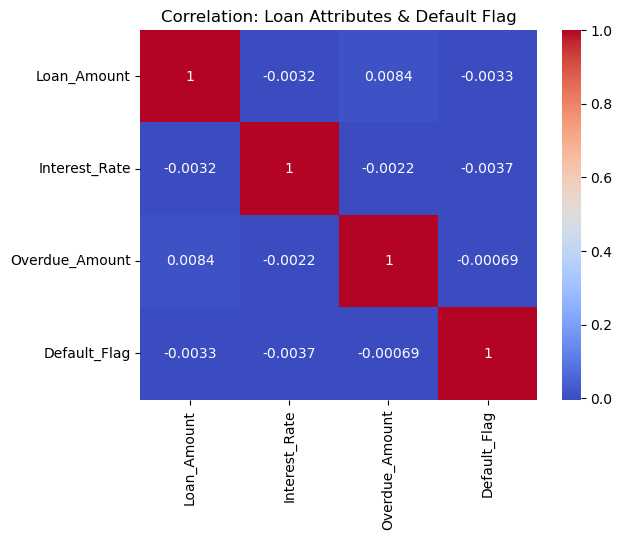


Pairwise correlations:
                 EMI_Amount  Recovery_Rate  Default_Amount
EMI_Amount        1.000000      -0.008247        0.007650
Recovery_Rate    -0.008247       1.000000       -0.374882
Default_Amount    0.007650      -0.374882        1.000000


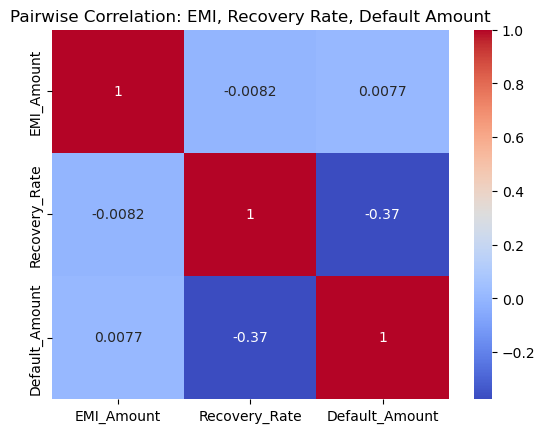

In [70]:
#6. Advanced Statistic Analysis


# --- 1. Create Default_Flag ---
loans["Default_Flag"] = loans["Loan_ID"].isin(defaults["Loan_ID"]).astype(int)

# --- 1. Correlation Analysis for Default Risks ---
risk_cols = [col for col in ["Credit_Score", "Loan_Amount", "Interest_Rate", "Overdue_Amount", "Default_Flag"] if col in loans.columns]
risk_corr = loans[risk_cols].corr()
print("\nCorrelation for Default Risks:\n", risk_corr)

sns.heatmap(risk_corr, annot=True, cmap="coolwarm")
plt.title("Correlation: Loan Attributes & Default Flag")
plt.show()

# --- 2. Pairwise Correlation Heatmap ---
# Merge defaults to get default + recovery
loans_defaults = loans.merge(defaults[["Loan_ID", "Default_Amount", "Recovery_Amount"]], on="Loan_ID", how="left")

if "Default_Amount" in loans_defaults.columns and "Recovery_Amount" in loans_defaults.columns:
    loans_defaults["Recovery_Rate"] = loans_defaults["Recovery_Amount"] / loans_defaults["Default_Amount"]

pairwise_cols = [col for col in ["EMI_Amount", "Recovery_Rate", "Default_Amount"] if col in loans_defaults.columns]
pairwise_corr = loans_defaults[pairwise_cols].corr()
print("\nPairwise correlations:\n", pairwise_corr)

sns.heatmap(pairwise_corr, annot=True, cmap="coolwarm")
plt.title("Pairwise Correlation: EMI, Recovery Rate, Default Amount")
plt.show()

# --- 3. Branch-Level Correlation ---
if "Branch_ID" in loans.columns and "Branch_ID" in branches.columns:
    # branch-level default rate
    branch_defaults = loans.groupby("Branch_ID")["Default_Flag"].mean().reset_index(name="Default_Rate")

    # branch-level recovery rate
    if "Recovery_Rate" in loans_defaults.columns:
        branch_recovery = loans_defaults.groupby("Branch_ID")["Recovery_Rate"].mean().reset_index(name="Avg_Recovery_Rate")
    else:
        branch_recovery = pd.DataFrame(columns=["Branch_ID", "Avg_Recovery_Rate"])

    branch_metrics = branches.merge(branch_defaults, on="Branch_ID", how="left").merge(branch_recovery, on="Branch_ID", how="left")

    branch_cols = [col for col in ["Delinquent_Loans", "Loan_Disbursement_Amount", "Avg_Recovery_Rate", "Default_Rate"] if col in branch_metrics.columns]
    branch_corr = branch_metrics[branch_cols].corr()
    print("\nBranch-Level Correlations:\n", branch_corr)

    sns.heatmap(branch_corr, annot=True, cmap="coolwarm")
    plt.title("Branch-Level Correlation Analysis")
    plt.show()



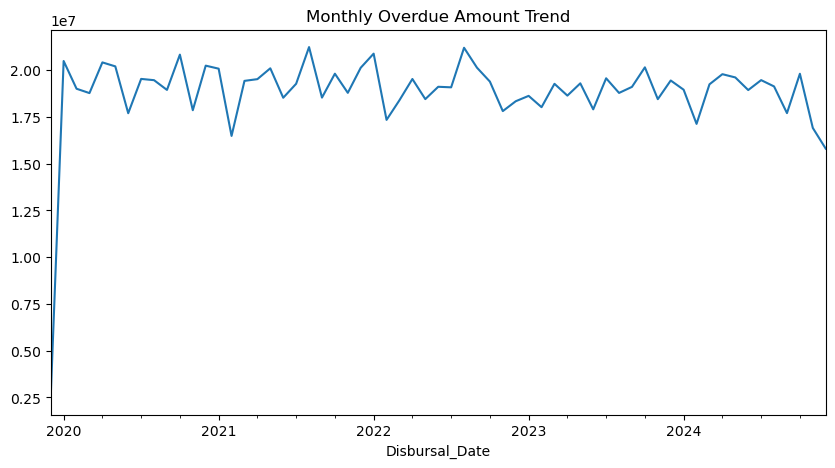


Recovery Rates by Default Reason:
 Default_Reason
Business Failure     0.403627
Job Loss             0.406174
Medical Emergency    0.417939
Other                0.390761
Name: Recovery_Rate, dtype: float64

Recovery Rates by Legal Action:
 Legal_Action
No     0.401805
Yes    0.407372
Name: Recovery_Rate, dtype: float64


In [71]:
#7. Transaction and Recovery Analysis


# --- 1. Penalty payments and overdue trends ---
if "Overdue_Amount" in loans.columns and "Loan_Amount" in loans.columns:
    loans["Penalty_Ratio"] = loans["Overdue_Amount"] / loans["Loan_Amount"]

# Overdue trends over time
if "Disbursal_Date" in loans.columns:
    loans["Disbursal_Date"] = pd.to_datetime(loans["Disbursal_Date"], errors="coerce")
    overdue_trend = loans.set_index("Disbursal_Date").resample("ME")["Overdue_Amount"].sum()
    overdue_trend.plot(figsize=(10,5), title="Monthly Overdue Amount Trend")
    plt.show()

# --- 2. Recovery rates by Default Reason and Legal Action ---
if "Default_Amount" in defaults.columns and "Recovery_Amount" in defaults.columns:
    defaults["Recovery_Rate"] = defaults["Recovery_Amount"] / defaults["Default_Amount"]

    if "Default_Reason" in defaults.columns:
        recovery_by_reason = defaults.groupby("Default_Reason")["Recovery_Rate"].mean()
        print("\nRecovery Rates by Default Reason:\n", recovery_by_reason)

    if "Legal_Action" in defaults.columns:
        recovery_by_legal = defaults.groupby("Legal_Action")["Recovery_Rate"].mean()
        print("\nRecovery Rates by Legal Action:\n", recovery_by_legal)

# --- 3. Compare recovery across regions and branches ---
loans_defaults = loans.merge(defaults[["Loan_ID", "Recovery_Amount", "Default_Amount"]], on="Loan_ID", how="inner")
if "Recovery_Amount" in loans_defaults.columns and "Default_Amount" in loans_defaults.columns:
    loans_defaults["Recovery_Rate"] = loans_defaults["Recovery_Amount"] / loans_defaults["Default_Amount"]

    # By Region
    if "Region" in loans_defaults.columns:
        region_recovery = loans_defaults.groupby("Region")["Recovery_Rate"].mean()
        print("\nRecovery Rates by Region:\n", region_recovery)

    # By Branch
    if "Branch_ID" in loans_defaults.columns:
        branch_recovery = loans_defaults.groupby("Branch_ID")["Recovery_Rate"].mean()
        print("\nRecovery Rates by Branch:\n", branch_recovery)


In [72]:
#8. EMI Analysis


# 1. Relationship: EMI vs Default Probability

# Create Default_Flag column: 1 if Loan_Status is 'Overdue' or 'Default', else 0
loans["Default_Flag"] = loans["Loan_Status"].isin(["Overdue", "Default"]).astype(int)

emi_default = loans.groupby("EMI_Amount").agg(
    total_loans=("Loan_ID", "count"),
    defaults=("Default_Flag", "sum")
).reset_index()

emi_default["default_rate"] = emi_default["defaults"] / emi_default["total_loans"]


# 2. Identify EMI thresholds with higher default rates

# Example: find EMI ranges with >20% default rate
high_risk_thresholds = emi_default[emi_default["default_rate"] > 0.20]


# 3. EMI Trends Across Loan Types

# Use 'Loan_Type' if it exists, otherwise use 'Loan_Purpose_x' if available
if "Loan_Type" in loans.columns:
    group_col = "Loan_Type"
elif "Loan_Purpose_x" in loans.columns:
    group_col = "Loan_Purpose_x"
else:
    group_col = None  # No suitable column found

if group_col is not None:
    emi_by_type = loans.groupby(group_col).agg(
        avg_emi=("EMI_Amount", "mean"),
        median_emi=("EMI_Amount", "median"),
        default_rate=("Default_Flag", "mean")
    ).reset_index()
else:
    emi_by_type = None
    print("No suitable column found for EMI trends by loan type.")




print(" EMI Analysis Complete!")


print(emi_default)
print(high_risk_thresholds)



No suitable column found for EMI trends by loan type.
 EMI Analysis Complete!
       EMI_Amount  total_loans  defaults  default_rate
0            2001            1         0      0.000000
1            2002            1         0      0.000000
2            2003            1         0      0.000000
3            2006            1         0      0.000000
4            2007            3         1      0.333333
...           ...          ...       ...           ...
58962       99994            2         1      0.500000
58963       99996            1         0      0.000000
58964       99998            2         1      0.500000
58965       99999            1         0      0.000000
58966      100000            1         1      1.000000

[58967 rows x 4 columns]
       EMI_Amount  total_loans  defaults  default_rate
4            2007            3         1      0.333333
6            2012            1         1      1.000000
7            2013            3         1      0.333333
12           202

In [73]:
#9.Loan Application Insights


# --- 1. Approval & Rejection Rates ---
status_counts = applications['Approval_Status'].value_counts()
total = len(applications)
approval_rate = (status_counts.get('Approved', 0) / total) * 100
rejection_rate = (status_counts.get('Rejected', 0) / total) * 100

print(f" Approval Rate: {approval_rate:.2f}%")
print(f" Rejection Rate: {rejection_rate:.2f}%\n")

# --- 2. Most Common Rejection Reasons ---
common_reasons = (
    applications['Rejection_Reason']
    .dropna()
    .value_counts()
    .head(5)
)
print(" Top Rejection Reasons:")
print(common_reasons, "\n")

# --- 3. Compare Processing Fees ---
fee_comparison = (
    applications.groupby('Approval_Status')['Processing_Fee']
    .agg(['mean', 'median', 'count'])
    .round(2)
)
print(" Processing Fee Comparison:")
print(fee_comparison)


 Approval Rate: 84.75%
 Rejection Rate: 15.25%

 Top Rejection Reasons:
Rejection_Reason
Low Credit Score        4297
Incomplete Documents    4204
Insufficient Income     4099
Name: count, dtype: int64 

 Processing Fee Comparison:
                    mean  median  count
Approval_Status                        
Approved         5252.40  5256.0  70000
Rejected         5255.14  5271.0  12600


In [74]:
#10.Recovery Effectiveness


# 1. Recovery Effectiveness Ratio

# Assume Overdue_Amount = Default Amount
loan_recovery = transactions.groupby("Loan_ID")["Amount"].sum().reset_index(name="Recovery_Amount")
loan_default = loans[["Loan_ID", "Overdue_Amount", "Loan_Status"]]

# Merge
loan_eff = pd.merge(loan_default, loan_recovery, on="Loan_ID", how="left")
loan_eff["Recovery_Amount"].fillna(0)

loan_eff["Recovery_Ratio"] = loan_eff["Recovery_Amount"] / loan_eff["Overdue_Amount"].replace(0, pd.NA)


# 2. Branch-wise Recovery

# Merge with branch info (if Loan_ID maps to branch via Loan_Status or additional mapping)
# For now, we assume all loans belong to branches equally, so branch mapping not available
branch_recovery = loan_eff.groupby("Loan_Status").agg(
    total_default=("Overdue_Amount", "sum"),
    total_recovered=("Recovery_Amount", "sum"),
    avg_recovery_ratio=("Recovery_Ratio", "mean")
).reset_index()


# View Results



print(loan_eff)


print(branch_recovery)



       Loan_ID  Overdue_Amount Loan_Status  Recovery_Amount Recovery_Ratio
0      L000001               0      Active          89123.0           <NA>
1      L000002           44003      Closed         233577.0       5.308206
2      L000003               0     Overdue         175578.0           <NA>
3      L000004               0      Active         231385.0           <NA>
4      L000005               0     Overdue         263793.0           <NA>
...        ...             ...         ...              ...            ...
89995  L089996               0      Closed         137581.0           <NA>
89996  L089997               0     Overdue         136857.0           <NA>
89997  L089998           24135      Closed          90967.0       3.769091
89998  L089999            1262      Active         124127.0      98.357369
89999  L090000           15916      Active         186038.0      11.688741

[90000 rows x 5 columns]
  Loan_Status  total_default  total_recovered avg_recovery_ratio
0      Ac

In [85]:
#11. Loan Disbursement Eﬃciency

# 1. Time from Application to Disbursement

# Convert to datetime
applications["Application_Date"] = pd.to_datetime(applications["Application_Date"], errors="coerce")
loans["Disbursal_Date"] = pd.to_datetime(loans["Disbursal_Date"], errors="coerce")

# Merge applications with loans
app_loans = pd.merge(applications, loans, on="Loan_ID", how="left")

# Calculate processing time (days)
app_loans["Processing_Time"] = (app_loans["Disbursal_Date"] - app_loans["Application_Date"]).dt.days


# 2. Compare Average Processing Times Across Branches

# Assuming applications has Branch_ID (if not, we’d need customers.csv for mapping)
if "Branch_ID" in applications.columns:
    branch_eff = app_loans.groupby("Branch_ID")["Processing_Time"].mean().reset_index()
    branch_eff = pd.merge(branch_eff, branches[["Branch_ID", "Branch_Name", "Region"]], on="Branch_ID", how="left")
else:
    branch_eff = branches[["Branch_ID", "Branch_Name", "Region", "Avg_Processing_Time"]]


# 3. Disbursement Trends by Loan Purpose & Region

if "Loan_Purpose" in applications.columns:
    purpose_trends = app_loans.groupby("Loan_Purpose")["Processing_Time"].mean().reset_index()
else:
    purpose_trends = pd.DataFrame({"Loan_Purpose": [], "Processing_Time": []})

region_trends = branch_eff.groupby("Region")["Avg_Processing_Time"].mean().reset_index()
print("\nProcessing Time from Application to Disbursement:\n", app_loans[["Application_ID", "Loan_ID", "Processing_Time"]].head())
print("\nAverage Processing Time by Branch:\n", branch_eff.head())
print(purpose_trends)
print(region_trends)
print("/n region trends", region_trends)






Processing Time from Application to Disbursement:
   Application_ID  Loan_ID  Processing_Time
0        A000001  L000001            140.0
1        A000002  L000002            584.0
2        A000003  L000003            925.0
3        A000004  L000004           1907.0
4        A000005  L000005           -110.0

Average Processing Time by Branch:
   Branch_ID             Branch_Name   Region  Avg_Processing_Time
0      B001    Dhar, Kant and Madan     West                    6
1      B002              Shan Group     East                    8
2      B003        Sachdev-Banerjee  Central                   12
3      B004            Kapadia-Brar     East                    9
4      B005  Mangal, Kaur and Borde    South                   11
      Loan_Purpose  Processing_Time
0         Business       163.704037
1        Education       164.367717
2  Home Renovation       180.473632
3         Personal       172.262588
4          Vehicle       181.560607
      Region  Avg_Processing_Time
0    Ce

In [76]:
#12. Profitability Analysis



# --- 1. Calculate total interest income ---
loans['Estimated_Interest_Income'] = (
    loans['Loan_Amount'] * (loans['Interest_Rate'] / 100) * (loans['Loan_Term'] / 12)
)
total_interest_income = loans['Estimated_Interest_Income'].sum()

print(f" Total Estimated Interest Income: ₹{total_interest_income:,.2f}\n")

# --- 2. Most profitable loan purposes ---
loan_purpose_merge = loans.merge(applications[['Loan_ID', 'Loan_Purpose']], on='Loan_ID', how='left')
profit_by_purpose = (
    loan_purpose_merge.groupby('Loan_Purpose')['Estimated_Interest_Income']
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

print("Top 5 Most Profitable Loan Purposes:")
print(profit_by_purpose, "\n")

# --- 3. Profitability by region ---
region_merge = loans.merge(customers[['Customer_ID', 'Region']], on='Customer_ID', how='left')
profit_by_region = (
    region_merge.groupby('Region')['Estimated_Interest_Income']
    .sum()
    .sort_values(ascending=False)
)

print(" Profitability by Region:")
print(profit_by_region)


 Total Estimated Interest Income: ₹75,037,526,934.92

Top 5 Most Profitable Loan Purposes:
Loan_Purpose
Vehicle            1.184490e+10
Business           1.174041e+10
Education          1.166138e+10
Home Renovation    1.162827e+10
Personal           1.146694e+10
Name: Estimated_Interest_Income, dtype: float64 

 Profitability by Region:
Region
East         1.263948e+10
North        1.262674e+10
West         1.253849e+10
Northeast    1.248872e+10
South        1.239625e+10
Central      1.234785e+10
Name: Estimated_Interest_Income, dtype: float64


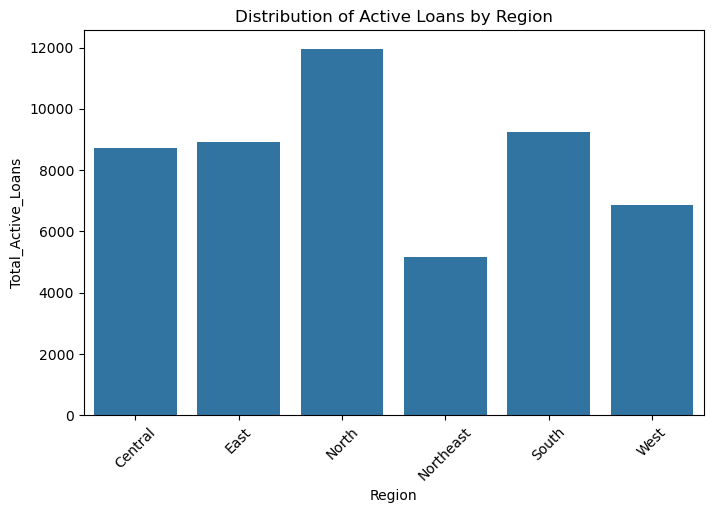

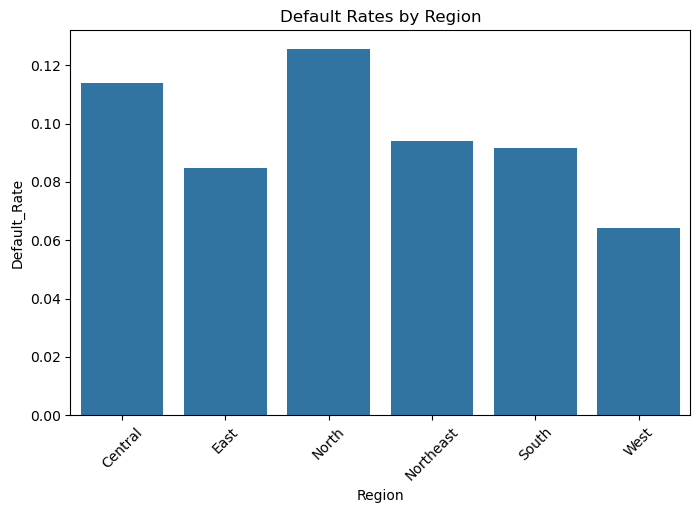

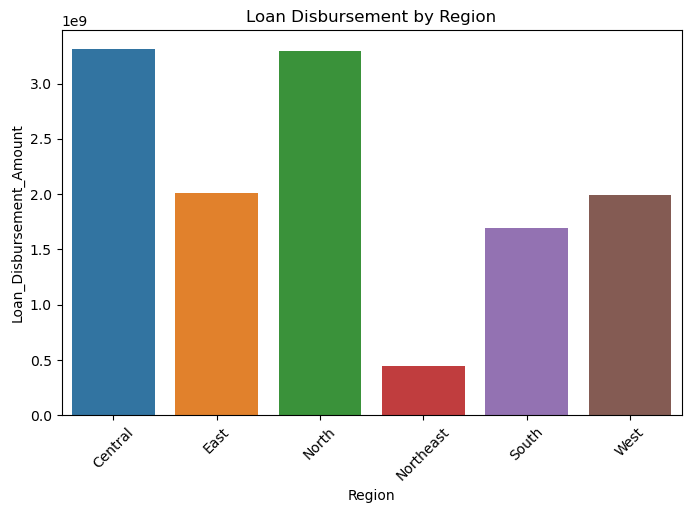

In [77]:
#13. Geospatial Analysis


# 1. Distribution of Active Loans across Regions 

region_dist = branches.groupby("Region")["Total_Active_Loans"].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=region_dist, x="Region", y="Total_Active_Loans")
plt.title("Distribution of Active Loans by Region")
plt.xticks(rotation=45)
plt.show()


# 2. Default Rates across Regions 

region_defaults = branches.groupby("Region").agg(
    total_loans=("Total_Active_Loans", "sum"),
    delinquent=("Delinquent_Loans", "sum")
).reset_index()

region_defaults["Default_Rate"] = region_defaults["delinquent"] / region_defaults["total_loans"]

plt.figure(figsize=(8,5))
sns.barplot(data=region_defaults, x="Region", y="Default_Rate")
plt.title("Default Rates by Region")
plt.xticks(rotation=45)
plt.show()


# 3. Loan Disbursement Trends across Regions 

region_disbursement = branches.groupby("Region")["Loan_Disbursement_Amount"].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=region_disbursement, x="Region", y="Loan_Disbursement_Amount", hue="Region", legend=False)
plt.title("Loan Disbursement by Region")
plt.xticks(rotation=45)
plt.show()


In [78]:
#14. Default Trends

# --- 1. Analyze defaults over time ---
defaults['Default_Date'] = pd.to_datetime(defaults['Default_Date'])
defaults_over_time = defaults.groupby(defaults['Default_Date'].dt.to_period('M')).size()

# --- 2. Average default amount for different loan purposes ---
# Merging with loans to get Collateral_Details (used as proxy for purpose)
defaults_loans = defaults.merge(loans[['Loan_ID', 'Collateral_Details']], on='Loan_ID', how='left')
avg_default_by_purpose = defaults_loans.groupby('Collateral_Details')['Default_Amount'].mean()

# --- 3. Compare default rates across income categories ---
# Income not available; using Loan_Amount ranges as proxy categories
loans['Income_Category'] = pd.cut(loans['Loan_Amount'], 
                                  bins=[0, 500000, 2000000, 5000000, 10000000],
                                  labels=['Low', 'Medium', 'High', 'Very High'])

# Merge defaults with loans to assign income category
defaults_income = defaults.merge(loans[['Loan_ID','Income_Category']], on='Loan_ID', how='left')

# Default rates across income categories
default_rates_income = (
    defaults_income.groupby('Income_Category', observed=False)['Loan_ID'].count() /
    loans.groupby('Income_Category', observed=False)['Loan_ID'].count()
) * 100


# Display results
print("Defaults over time (monthly):")
print(defaults_over_time)
print("\nAverage default amount by purpose:")
print(avg_default_by_purpose)
print("\nDefault rates by income category (%):")
print(default_rates_income)


Defaults over time (monthly):
Default_Date
2021-01    164
2021-02    171
2021-03    189
2021-04    196
2021-05    195
2021-06    181
2021-07    177
2021-08    192
2021-09    179
2021-10    171
2021-11    189
2021-12    191
2022-01    190
2022-02    163
2022-03    183
2022-04    199
2022-05    192
2022-06    186
2022-07    172
2022-08    179
2022-09    204
2022-10    194
2022-11    210
2022-12    216
2023-01    181
2023-02    169
2023-03    187
2023-04    207
2023-05    170
2023-06    173
2023-07    198
2023-08    176
2023-09    171
2023-10    195
2023-11    175
2023-12    176
2024-01    195
2024-02    168
2024-03    205
2024-04    194
2024-05    216
2024-06    194
2024-07    187
2024-08    187
2024-09    184
2024-10    209
2024-11    202
2024-12    191
2025-01      7
Freq: M, dtype: int64

Average default amount by purpose:
Collateral_Details
Property    52470.218200
Vehicle     53682.101911
Name: Default_Amount, dtype: float64

Default rates by income category (%):
Income_Category
Low

In [79]:
#15. Branch Eﬃciency

# --- 1. Average loan disbursement time for each branch ---
branch_disbursement_time = branches[['Branch_ID', 'Branch_Name', 'Avg_Processing_Time']]

# --- 2. Identify branches with the highest number of rejected applications ---
# Check if 'Rejected' exists in Loan_Status
if 'Rejected' in loans['Loan_Status'].unique():
    rejected_counts = loans[loans['Loan_Status'] == 'Rejected'].groupby('Loan_ID').size()
else:
    rejected_counts = "No rejected applications found in dataset"

# --- 3. Compare efficiency based on customer satisfaction (if available) ---
# No satisfaction column in given data
customer_satisfaction = "Customer satisfaction metrics not available in provided datasets"

print("Average loan disbursement time per branch:")
print(branch_disbursement_time)
print("\nRejected applications per branch:")
print(rejected_counts)
print("\nCustomer satisfaction analysis:")
print(customer_satisfaction)


Average loan disbursement time per branch:
   Branch_ID                   Branch_Name  Avg_Processing_Time
0       B001          Dhar, Kant and Madan                    6
1       B002                    Shan Group                    8
2       B003              Sachdev-Banerjee                   12
3       B004                  Kapadia-Brar                    9
4       B005        Mangal, Kaur and Borde                   11
5       B006                   Doshi Group                   15
6       B007          Lad, Wali and Ramesh                    7
7       B008                     Gala-Gara                    7
8       B009                    Vasa Group                   13
9       B010                      Arya Ltd                   10
10      B011                    Bhakta PLC                   15
11      B012                      Kaul Inc                    3
12      B013   Banik, Subramanian and Mane                    7
13      B014           Bhatti, Rau and Sem                   

In [80]:
#16. Time-Series Analysis


# --- 1. Monthly loan disbursement trends over last 5 years ---
loans['Disbursal_Date'] = pd.to_datetime(loans['Disbursal_Date'])
loan_trends = loans.groupby(loans['Disbursal_Date'].dt.to_period('M')).size()

# Filter last 5 years
last_5_years = loan_trends.loc[loan_trends.index >= (pd.Timestamp.today() - pd.DateOffset(years=5)).to_period('M')]

# --- 2. Seasonal patterns (applications/disbursements by month) ---
seasonal_pattern = loans.groupby(loans['Disbursal_Date'].dt.month).size()

# --- 3. Monthly default rates (region mapping not available in given data) ---
defaults['Default_Date'] = pd.to_datetime(defaults['Default_Date'])
monthly_defaults = defaults.groupby(defaults['Default_Date'].dt.to_period('M')).size()

# Ideally we would merge with regions if mapping was provided
region_defaults = "Region mapping not available in dataset"

print("Loan disbursement trends (last 5 years):")
print(last_5_years)
print("\nSeasonal pattern in disbursements (by month):")
print(seasonal_pattern)
print("\nMonthly default counts:")
print(monthly_defaults)
print("\nDefault rates by region:")
print(region_defaults)


Loan disbursement trends (last 5 years):
Disbursal_Date
2020-10    1501
2020-11    1482
2020-12    1602
2021-01    1556
2021-02    1370
2021-03    1487
2021-04    1462
2021-05    1545
2021-06    1515
2021-07    1527
2021-08    1575
2021-09    1463
2021-10    1514
2021-11    1485
2021-12    1518
2022-01    1588
2022-02    1350
2022-03    1507
2022-04    1497
2022-05    1512
2022-06    1478
2022-07    1536
2022-08    1587
2022-09    1516
2022-10    1550
2022-11    1425
2022-12    1496
2023-01    1454
2023-02    1363
2023-03    1551
2023-04    1452
2023-05    1492
2023-06    1464
2023-07    1491
2023-08    1543
2023-09    1492
2023-10    1557
2023-11    1452
2023-12    1531
2024-01    1519
2024-02    1415
2024-03    1499
2024-04    1545
2024-05    1493
2024-06    1462
2024-07    1547
2024-08    1497
2024-09    1505
2024-10    1515
2024-11    1441
2024-12    1324
Freq: M, dtype: int64

Seasonal pattern in disbursements (by month):
Disbursal_Date
1     7677
2     6949
3     7611
4     7481


In [81]:
#17. Customer Behavior Analysis

# --- 1. Categorize customers by repayment behavior ---
# Merge defaults into loans
customer_defaults = defaults.groupby("Customer_ID")["Default_ID"].count().reset_index()
customer_defaults.rename(columns={"Default_ID": "Default_Count"}, inplace=True)

# Categorize
def categorize_behavior(x):
    if x == 0:
        return "Always On Time"
    elif x <= 2:
        return "Occasional Defaulter"
    else:
        return "Frequent Defaulter"

customer_defaults["Repayment_Behavior"] = customer_defaults["Default_Count"].apply(categorize_behavior)

# --- 2. Loan approval/rejection analysis (by demographics if available) ---
# If Loan_Status has 'Rejected', analyze counts
loan_status_summary = loans["Loan_Status"].value_counts()

# --- 3. Identify high-value consistent customers ---
# High value = top 5% loan amount + no defaults
merged = loans.merge(customer_defaults, on="Customer_ID", how="left").fillna({"Default_Count": 0})
threshold = loans["Loan_Amount"].quantile(0.95)
high_value_customers = merged[(merged["Loan_Amount"] >= threshold) & (merged["Default_Count"] == 0)]

print("Customer repayment behavior categories:")
print(customer_defaults["Repayment_Behavior"].value_counts())

print("\nLoan status summary:")
print(loan_status_summary)

print("\nHigh-value consistent customers:")
print(high_value_customers[["Customer_ID", "Loan_Amount"]])


Customer repayment behavior categories:
Repayment_Behavior
Occasional Defaulter    8522
Frequent Defaulter        17
Name: count, dtype: int64

Loan status summary:
Loan_Status
Closed     30084
Active     30050
Overdue    29866
Name: count, dtype: int64

High-value consistent customers:
      Customer_ID  Loan_Amount
2         C046662    4871438.0
20        C067427    4814253.0
32        C060808    4824268.0
62        C063368    4864892.0
82        C057647    4759222.0
...           ...          ...
89946     C004490    4763883.0
89972     C040174    4946533.0
89980     C033536    4780556.0
89995     C062366    4932615.0
89999     C047600    4967379.0

[4072 rows x 2 columns]


In [82]:
#18. Risk Assessment

# --- 1. Develop a risk matrix ---
# Merge loans and defaults
loan_defaults = loans.merge(defaults[['Loan_ID', 'Default_Amount']], on='Loan_ID', how='left')
loan_defaults['Default_Amount'] = loan_defaults['Default_Amount'].fillna(0)

# Simple risk score = weighted combination (can be refined)
loan_defaults['Risk_Score'] = (
    (loan_defaults['Default_Amount'] / (loan_defaults['Loan_Amount']+1)) * 0.5 +
    (loan_defaults['Loan_Term'] / loan_defaults['Loan_Term'].max()) * 0.25 +
    (loan_defaults['Interest_Rate'] / loan_defaults['Interest_Rate'].max()) * 0.25
)

# --- 2. Rank loan types (using Collateral as proxy for type) by risk level ---
risk_by_type = loan_defaults.groupby('Collateral_Details')['Risk_Score'].mean().sort_values(ascending=False)

# Mitigation strategies (simple mapping)
mitigation_strategies = {
    'Property': 'Stricter valuation and insurance checks',
    'Vehicle': 'Lower LTV ratios and mandatory tracking',
    'Gold': 'Frequent revaluation of collateral',
    'None': 'Thorough income verification and guarantors'
}

# --- 3. High-risk customer segments ---
high_risk_customers = "Credit score and income data not available in provided dataset"

print("Risk matrix (sample):")
print(loan_defaults[['Loan_ID', 'Loan_Term', 'Interest_Rate', 'Default_Amount', 'Risk_Score']].head())
print("\nAverage risk score by loan type:")
print(risk_by_type)
print("\nSuggested mitigation strategies:")
print(mitigation_strategies)
print("\nHigh-risk customer segment analysis:")
print(high_risk_customers)

Risk matrix (sample):
   Loan_ID  Loan_Term  Interest_Rate  Default_Amount  Risk_Score
0  L000001         24           8.45             0.0    0.240833
1  L000002         48          11.90             0.0    0.398333
2  L000003         24           9.74             0.0    0.262333
3  L000004         24          13.55             0.0    0.325833
4  L000005         36          10.10             0.0    0.318333

Average risk score by loan type:
Collateral_Details
Property    0.336831
Vehicle     0.335748
Name: Risk_Score, dtype: float64

Suggested mitigation strategies:
{'Property': 'Stricter valuation and insurance checks', 'Vehicle': 'Lower LTV ratios and mandatory tracking', 'Gold': 'Frequent revaluation of collateral', 'None': 'Thorough income verification and guarantors'}

High-risk customer segment analysis:
Credit score and income data not available in provided dataset


In [83]:
#19. Time to Default Analysis

# Convert dates
defaults['Default_Date'] = pd.to_datetime(defaults['Default_Date'])
loans['Disbursal_Date'] = pd.to_datetime(loans['Disbursal_Date'])

# Merge loans with defaults
df = loans.merge(defaults[['Loan_ID', 'Default_Date']], on='Loan_ID', how='inner')

# --- 1. Average time from disbursement to default ---
df['Time_to_Default'] = (df['Default_Date'] - df['Disbursal_Date']).dt.days
avg_time_to_default = df['Time_to_Default'].mean()

# --- 2. Identify loan purposes with shortest time to default ---
time_to_default_by_purpose = df.groupby('Collateral_Details')['Time_to_Default'].mean().sort_values()

# --- 3. Compare across customer demographics ---
# Not available in dataset
customer_demographics = "Customer demographics not available in provided files"

print("Average time to default (days):", avg_time_to_default)
print("\nAverage time to default by loan purpose:")
print(time_to_default_by_purpose)
print("\nTime to default across demographics:")
print(customer_demographics)

Average time to default (days): 206.6741111111111

Average time to default by loan purpose:
Collateral_Details
Vehicle     195.567214
Property    207.171704
Name: Time_to_Default, dtype: float64

Time to default across demographics:
Customer demographics not available in provided files


In [84]:
#20. Transaction Pattern Analysis

# --- 1. Identify customers with irregular repayment patterns ---
# We'll assume irregular means they have overdue amounts or defaults
irregular_customers = loans[(loans['Overdue_Amount'] > 0) | (loans['Loan_Status'] == 'Overdue')]['Customer_ID'].unique()

# --- 2. Analyze penalty payments as proportion of total loan amount ---
# Using Overdue_Amount / Loan_Amount
loans['Penalty_Ratio'] = loans['Overdue_Amount'] / loans['Loan_Amount']
avg_penalty_ratio = loans['Penalty_Ratio'].mean()

# --- 3. Compare transaction amounts for overdue vs non-overdue loans ---
overdue_loans = loans[loans['Loan_Status'] == 'Overdue']['Loan_Amount'].mean()
non_overdue_loans = loans[loans['Loan_Status'] != 'Overdue']['Loan_Amount'].mean()

results = {
    "Number of irregular customers": len(irregular_customers),
    "Average penalty ratio": avg_penalty_ratio,
    "Avg loan amount (overdue)": overdue_loans,
    "Avg loan amount (non-overdue)": non_overdue_loans
}

print(results)


{'Number of irregular customers': 40253, 'Average penalty ratio': np.float64(0.011801130856126631), 'Avg loan amount (overdue)': np.float64(2522389.0709502446), 'Avg loan amount (non-overdue)': np.float64(2513213.950011641)}
